In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Pronósticos de Series de Tiempo
## Ejercicio Práctico Modelo LSTM
### Semana 2 a semana 5


Parte I: Solución práctica de un problema de pronóstico a un activo financiero particular. Sigue estas indicaciones:

1. Descarga de Yahoo Finance la serie de precios de cierre del activo META en las fechas: 01-05-2016 al 28-01-2018.

2. Grafica la serie.

3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.

4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.

5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos. En el caso de LSTM diseña y entrena la red con 200 nodos, la función de activación “relu”, epochs=30, función de perdida de ‘mse’, longitud de ventana de 10 yoptimizer='adam'.

6. Aplica cada uno de los modelos MARS, LSTM, RF y SSA a la serie de META. Te puedes apoyar en los tutoriales realizados durante estas semanas.

7. Empleando tus resultados, calcula las métricas para la medición de asertividad de un pronóstico, al menos debescalcular dos métricos de error de pronóstico, ejemplo: MAPE, RMSE, MAE, entre otros.

In [59]:
#Importar librerías
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import plotly.graph_objs as go

# univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [60]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

In [61]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
#Establecemos las fechas de consulta:
start = '2016-05-01'
end = '2018-01-28'
ticker='META'
data = pdr.get_data_yahoo(ticker, start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [63]:
dt= pandas.DataFrame(data)
dt.head()

,Close
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


In [64]:
len(dt)

439

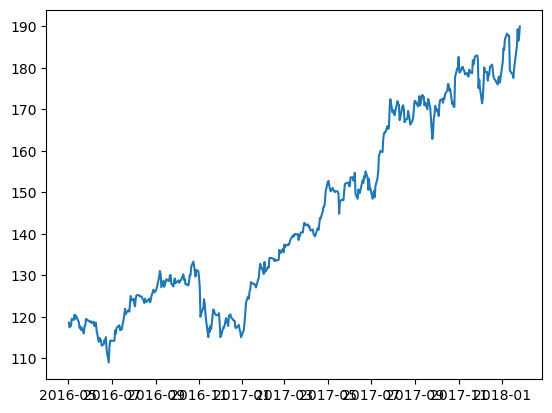

In [65]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

In [66]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(dt.index)
dataindex

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26'],
              dtype='datetime64[ns]', name='Date', length=439, freq=None)

In [67]:
#Ahora, a numpy array:
dt2= data.to_numpy()
dt

,Close
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998
...,...
2018-01-22,185.369995
2018-01-23,189.350006
2018-01-24,186.550003


In [68]:
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 signigica que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))
close_data

array([[118.56999969],
       [117.43000031],
       [118.05999756],
       [117.80999756],
       [119.48999786],
       [119.23999786],
       [120.5       ],
       [119.51999664],
       [120.27999878],
       [119.80999756],
       [118.66999817],
       [117.34999847],
       [117.65000153],
       [116.80999756],
       [117.34999847],
       [115.97000122],
       [117.69999695],
       [117.88999939],
       [119.47000122],
       [119.37999725],
       [118.80999756],
       [118.77999878],
       [118.93000031],
       [118.47000122],
       [118.79000092],
       [117.76000214],
       [118.38999939],
       [118.55999756],
       [116.62000275],
       [113.94999695],
       [114.94000244],
       [114.59999847],
       [114.38999939],
       [113.01999664],
       [113.37000275],
       [114.37999725],
       [113.91000366],
       [115.08000183],
       [112.08000183],
       [108.97000122],
       [112.69999695],
       [114.16000366],
       [114.27999878],
       [114

In [69]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [70]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(close_train))
print(len(close_test))

417
22


In [86]:
#Especificamos la longitud o length, es el número de observaciones tipo lags a emplear en la porción de entrada de cada muestra
#batch size representa en número de sub-series o muestras a generar en cada lote. 
#En este caso, pueden ser uno o más. Por ejemplo, en la imagen anterior,

n_back = 10   #la longitud 
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)     
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

In [87]:
# Podemos ver el número de muestras que se prepararán en los datos por el generador para esta serie
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))


Samples: 17
Samples: 12


In [88]:
##Se diseña la red neuronal '

# En este caso se diseña y entrena la red con:
    #200 nodos, 
    #la función de activación “relu”, 
    #epochs=30, 
    #función de perdida de ‘mse’,
    #longitud de ventana de 10 
    #optimizer='adam'.

#Importamos primero los módulos requeridos:
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(200,  ## de nodos, dependerá de su poder de cómputo.
        activation='relu', #función de activación.
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

In [89]:
##Ajuste del modelo a los datos:
history = model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

In [90]:
#Imprimimos gráfico de función de pérdida acorde los epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
]

plot_layout = go.Layout(
        title='Training loss')
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [91]:
#Importamos primero el módulo para generar el gráfico animado.
import pandas as pd
import plotly.graph_objects as go

In [92]:
#Predicción en el set de prueba:
prediction = model.predict_generator(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [93]:
#Podemos primeramente graficar las secciones: la serie de entrenamiento, la predicción en la sección de prueba y la sección de prueba.
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Reality'
)
layout = go.Layout(
    title = "Meta Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

## Pronóstico del Modelo LSTM

In [94]:
##Identificamos la posición del último valor de la serie. Se puede emplear tambien la función de max, tal como: dataindex.index.max().
dataindex.max()

Timestamp('2018-01-26 00:00:00')

In [95]:
##Forecasting: Generamos el pronóstico hacia adelante acorde el modelo entrenado, a partir de la última fecha. en este caso generaremos 10 observaciones futuras y finalmente anexaremos las fechas correspondientes.
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = dataindex.max()  #se podría sustituir por un objeto con el valor máximo de la longitud de la serie.
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()  #Aquí, sebemos ser coherentes con la frecuencia de la serie, el defalult es diario.
    return prediction_dates

num_prediction = 10
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 25ms/step


In [96]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Reality'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'FWD Forecast'
)

layout = go.Layout(
    title = "META Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

In [97]:
len(prediction)
actual=close_test[:12]

12

In [99]:
#Calcular el RMSE
#importar las bibliotecas necesarias 
from sklearn.metrics import mean_squared_error
from math import sqrt

#calcular RMSE
RMSE=sqrt (mean_squared_error (actual, prediction))
RMSE

4.701141139429323

In [100]:
from sklearn.metrics import mean_absolute_error
MAE=(mean_absolute_error (actual, prediction))
MAE

4.393494923909505

*Elaborado por Rebeca Gamboa para el curso de Pronósticos, MIAD*